In [44]:
import pandas as pd
import scipy as sc
import glob
import os
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
# %load_ext blackcellmagic
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import plotting

In [73]:
from bootstrap import bootstrap

In [47]:
systems = """./a-bam-p
./a-bam-s
./a-but-p
./a-but-s
./a-cbu-p
./a-chp-p
./a-cbu-s
./a-chp-s
./a-cpe-p
./a-coc-p
./a-coc-s
./a-cpe-s
./a-hep-p
./a-ham-s
./a-ham-p
./a-hep-s
./a-hp6-p
./a-hex-p
./a-hex-s
./a-hp6-s
./a-hx2-p
./a-hpa-s
./a-hpa-p
./a-hx2-s
./a-mba-p
./a-hx3-s
./a-hx3-p
./a-mba-s
./a-mhp-p
./a-mha-p
./a-mha-s
./a-mhp-s
./a-nmh-p
./a-nmb-p
./a-nmb-s
./a-nmh-s
./a-oct-p
./a-oam-p
./a-oam-s
./a-oct-s
./a-pnt-p
./a-pam-p
./a-pam-s
./a-pnt-s
./b-ben-s
./a-xxxx-s
./b-ben-p
./b-cbu-p
./b-cbu-s
./b-chp-s
./b-chp-p
./b-coc-s
./b-coc-p
./b-cpe-s
./b-cpe-p
./b-ham-s
./b-ham-p
./b-hep-s
./b-hep-p
./b-hex-p
./b-hex-s
./b-m4c-s
./b-m4c-p
./b-m4t-p
./b-m4t-s
./b-mch-s
./b-mha-s
./b-mha-p
./b-mch-p
./b-mo3-s
./b-mo4-p
./b-mo4-s
./b-mo3-p
./b-mp3-s
./b-mp4-s
./b-mp4-p
./b-mp3-p
./b-oam-s
./b-pb3-s
./b-pb3-p
./b-oam-p
./b-pb4-s
./b-pha-s
./b-pb4-p
./b-pha-p
./b-pnt-s
./b-pnt-p"""
systems = systems.split("\n")
systems = [i[2:] for i in systems]
systems = [i for i in systems if "xxxx" not in i]

In [48]:
import json
end_point_energies = {}
for system in systems:
    end_point_energies[system] = {}
    for ff in ["smirnoff", "bgbg_tip3p"]:
        try:
            with open(f"results/enthalpy/{system}-{ff}-enthalpy-full.json", "r") as f:
                 end_point_energies[system][ff] = json.load(f)
        except:
            pass

In [49]:
experimental_values = """a-bam	-2.17	0.05
a-nmb	-2.57	0.06
a-mba	-2.68	0.07
a-pam	-3.28	0.02
a-ham	-4.19	0.02
a-nmh	-4.20	0.08
a-mha	-4.28	0.02
a-hpa	-4.66	0.02
a-mhp	-4.74	0.02
a-oam	-5.46	0.03
b-ham	0.60	0.05
b-mha	0.47	0.03
b-oam	-0.48	0.03
a-cbu	-2.75	0.05
a-cpe	-2.74	0.02
a-chp	-2.99	0.23
a-coc	-0.93	0.32
b-cbu	0.88	0.17
b-cpe	-1.09	0.01
b-mch	-2.29	0.03
b-m4c	-2.27	0.01
b-m4t	-2.17	0.02
b-chp	-2.96	0.01
b-coc	-3.92	0.06
a-but	-2.53	0.12
a-pnt	-2.75	0.01
a-hex	-3.40	0.02
a-hx2	-4.12	0.06
a-hx3	-3.36	0.05
a-hep	-4.19	0.09
a-hp6	-4.48	0.02
a-oct	-4.89	0.03
b-pnt	1.89	0.53
b-hex	1.31	0.04
b-hep	0.42	0.04
b-ben	-2.51	0.08
b-pha	-1.79	0.11
b-mp3	-2.75	0.13
b-mp4	-2.89	0.05
b-mo3	-2.93	0.03
b-mo4	-1.96	0.01
b-pb3	-2.25	0.01
b-pb4	-2.82	0.01"""

In [57]:
chemical_types = {
    'aliphatic_ammoniums': ['a-bam', 'a-nmb', 'a-mba', 'a-pam', 'a-ham', 'a-nmh', 'a-mha', 'a-hpa', 'a-mhp', 'a-oam', 'b-ham', 'b-mha', 'b-oam'],
    'cyclic_alcohols': ['a-cbu', 'a-cpe', 'a-chp', 'a-coc', 'b-cbu', 'b-cpe', 'b-mch', 'b-m4c', 'b-m4t', 'b-chp', 'b-coc'],
    'aliphatic_carboxylates': ['a-but', 'a-pnt', 'a-hex', 'a-hx2', 'a-hx3', 'a-hep', 'a-hp6', 'a-oct', 'b-pnt', 'b-hex', 'b-hep', 'b-ben', 
                              'b-pha', 'b-mp3', 'b-mp4', 'b-mo3', 'b-mo4', 'b-pb3', 'b-pb4'],
}
guest_types = {}
for k, v in chemical_types.items():
    for i in v:
        guest_types[i] = k

In [58]:
combined = pd.DataFrame()
for system in systems:
    guest = "-".join(system.split("-")[0:2])
    for ff in ["smirnoff", "bgbg_tip3p"]:

        if ff == "smirnoff":
            windows = ["a000", "r014"]
        else:
            windows = ["a00", "r00"]

        combined = combined.append(
            pd.DataFrame(
                {
                    "system": system,
                    "ff": ff,
                    "guest_type": guest_types[guest],
                    "total": end_point_energies[system][ff][windows[0]]["total"][0]
                    - end_point_energies[system][ff][windows[1]]["total"][0],
                    "bond": end_point_energies[system][ff][windows[0]]["bond"][0]
                    - end_point_energies[system][ff][windows[1]]["bond"][0],
                    "ang": end_point_energies[system][ff][windows[0]]["ang"][0]
                    - end_point_energies[system][ff][windows[1]]["ang"][0],
                    "dih": end_point_energies[system][ff][windows[0]]["dih"][0]
                    - end_point_energies[system][ff][windows[1]]["dih"][0],
                    "v14": end_point_energies[system][ff][windows[0]]["v14"][0]
                    - end_point_energies[system][ff][windows[1]]["v14"][0],
                    "e14": end_point_energies[system][ff][windows[0]]["e14"][0]
                    - end_point_energies[system][ff][windows[1]]["e14"][0],
                    "ele": end_point_energies[system][ff][windows[0]]["ele"][0]
                    - end_point_energies[system][ff][windows[1]]["ele"][0],
                    "vdw": end_point_energies[system][ff][windows[0]]["vdw"][0]
                    - end_point_energies[system][ff][windows[1]]["vdw"][0],
                    "total_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["total"][1] ** 2
                        + end_point_energies[system][ff][windows[1]]["total"][1] ** 2
                    ),
                    "bond_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["bond"][1] ** 2
                        + end_point_energies[system][ff][windows[1]]["bond"][1]**2
                    ),
                    "ang_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["ang"][1]**2
                       + end_point_energies[system][ff][windows[1]]["ang"][1]**2
                    ),
                    "dih_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["dih"][1]**2
                        + end_point_energies[system][ff][windows[1]]["dih"][1]**2
                    ),
                    "v14_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["v14"][1]**2
                        + end_point_energies[system][ff][windows[1]]["v14"][1]**2
                    ),
                    "e14_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["e14"][1]**2
                        + end_point_energies[system][ff][windows[1]]["e14"][1]**2
                    ),
                    "ele_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["ele"][1]**2
                        + end_point_energies[system][ff][windows[1]]["ele"][1]**2
                    ),
                    "vdw_sem": np.sqrt(
                        end_point_energies[system][ff][windows[0]]["vdw"][1]**2
                        + end_point_energies[system][ff][windows[1]]["vdw"][1]**2
                    ),
                },
                index=[0],
            ),
            ignore_index=True,
        )


In [83]:
combined

,system,ff,guest_type,total,bond,ang,dih,v14,e14,ele,vdw,total_sem,bond_sem,ang_sem,dih_sem,v14_sem,e14_sem,ele_sem,vdw_sem,short_system
0,a-bam-p,smirnoff,aliphatic_ammoniums,-0.415793,-0.579071,-2.835390,6.160620,0.324268,1.192770,-1.794717,-2.884273,0.284361,0.175875,0.582619,1.544267,0.137161,0.368707,0.627553,0.387463,a-bam
1,a-bam-p,bgbg_tip3p,aliphatic_ammoniums,0.437966,-1.243355,-4.135906,10.380199,-0.372843,-2.854269,2.329849,-3.665709,0.628791,0.147642,0.322548,0.867134,0.322592,0.757144,0.713160,0.368643,a-bam
2,a-bam-s,smirnoff,aliphatic_ammoniums,-1.186330,-1.144173,-5.099978,11.244437,-0.147084,-1.297088,-0.519521,-4.222923,0.346565,0.083063,0.101962,0.430738,0.188989,0.496606,0.634766,0.157583,a-bam
3,a-bam-s,bgbg_tip3p,aliphatic_ammoniums,-1.346366,-0.170636,-1.461660,1.985867,0.430966,0.461485,-0.587298,-2.005091,0.719068,0.299581,0.734257,2.450116,0.271101,0.908913,1.088099,0.640342,a-bam
4,a-but-p,smirnoff,aliphatic_carboxylates,-1.858512,-0.516884,-2.280305,5.103392,0.026722,1.051737,-2.579284,-2.663889,0.242547,0.076117,0.342377,0.813169,0.101793,0.322756,0.457723,0.283971,a-but
5,a-but-p,bgbg_tip3p,aliphatic_carboxylates,-0.070088,-0.507748,-1.600585,4.871126,0.020299,0.563869,-0.975555,-2.441493,0.686248,0.219857,0.626124,1.583609,0.365953,0.922418,1.132328,0.518808,a-but
6,a-but-s,smirnoff,aliphatic_carboxylates,-0.672305,-0.294329,-0.165416,2.371365,0.235360,1.491535,-2.518868,-1.791953,0.636858,0.211348,0.199150,1.188409,0.274716,0.576655,0.778128,0.231676,a-but
7,a-but-s,bgbg_tip3p,aliphatic_carboxylates,-1.538708,-0.489777,-1.794638,5.097899,0.322417,1.093161,-3.636598,-2.131172,0.291459,0.019711,0.091252,0.223283,0.037370,0.145453,0.399888,0.177677,a-but
8,a-cbu-p,smirnoff,cyclic_alcohols,-2.114387,-0.345984,-1.707013,4.489847,0.149151,2.036281,-3.085119,-3.651551,0.222378,0.100094,0.360306,0.888394,0.133161,0.349701,0.415945,0.193342,a-cbu
9,a-cbu-p,bgbg_tip3p,cyclic_alcohols,-0.284187,-0.481816,-1.595875,4.573384,-0.112832,0.353770,-0.493681,-2.527137,0.312583,0.135193,0.456728,1.054438,0.277696,0.654553,0.761542,0.351987,a-cbu


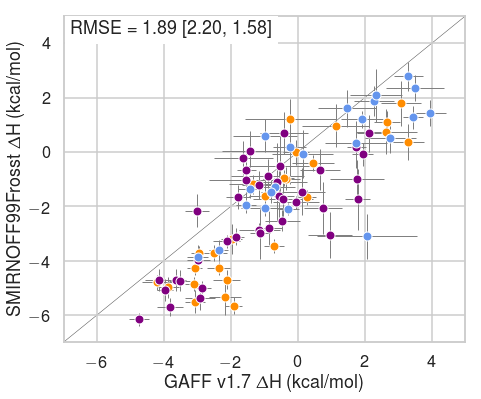

In [95]:
guest_types = combined["guest_type"].unique()

colors = {'aliphatic_ammoniums': 'darkorange',
          'cyclic_alcohols': 'cornflowerblue',
          'aliphatic_carboxylates': 'purple'
}

statistics = bootstrap(
    combined[combined["ff"] == "bgbg_tip3p"]["total"].values,
    combined[combined["ff"] == "bgbg_tip3p"]["total_sem"].values,
    combined[combined["ff"] == "smirnoff"]["total"].values,
    combined[combined["ff"] == "smirnoff"]["total_sem"].values,
    cycles=1000,
)


fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

for index, guest_type in enumerate(guest_types):
    df = combined[combined["guest_type"] == guest_type]
    df_x = df[df["ff"] == "bgbg_tip3p"]
    df_y = df[df["ff"] == "smirnoff"]
    ax.errorbar(
        df_x["total"],
        df_y["total"],
        xerr=df_x["total_sem"],
        yerr=df_y["total_sem"],
        fmt="o",
        c=colors[guest_type],
        markeredgecolor="w",
        ecolor="0.5",
        elinewidth=1,
    )
    
ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-7, 5)
ax.set_xlim(-7, 5)
ax.set_ylabel("SMIRNOFF99Frosst $\Delta$H (kcal/mol)", labelpad=5)
ax.set_xlabel("GAFF v1.7 $\Delta$H (kcal/mol)", labelpad=5)

bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.0, alpha=1)
text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
ax.annotate(
    text,
    xy=(-7 + 0.21, 5 - 0.21),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
)

plt.savefig("SMIRNOFF-vs-GAFF-deltaH.pdf")

In [ ]:
guest_types = combined["guest_type"].unique()

colors = {'aliphatic_ammoniums': 'darkorange',
          'cyclic_alcohols': 'cornflowerblue',
          'aliphatic_carboxylates': 'purple'
}


fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

for index, guest_type in enumerate(guest_types):
    df = combined[combined["guest_type"] == guest_type]
    df_x = df[df["ff"] == "bgbg_tip3p"]
    df_y = df[df["ff"] == "smirnoff"]
    ax.errorbar(
        df_x["total"],
        df_y["total"],
        xerr=df_x["total_sem"],
        yerr=df_y["total_sem"],
        fmt="o",
        c=colors[guest_type],
        markeredgecolor="w",
        ecolor="0.5",
        elinewidth=1,
    )


ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-7, 5)
ax.set_xlim(-7, 5)
ax.set_ylabel("SMIRNOFF99Frosst $\Delta$H (kcal/mol)", labelpad=5)
ax.set_xlabel("GAFF v1.7 $\Delta$H (kcal/mol)", labelpad=5)

total
{'mean': {'slope': 0.82609592612294402, 'intercept': -1.2530755785465781, 'R': 0.77780732391281437, 'R**2': 0.60730963481352818, 'RMSE': 1.8989149478681746}, 'sem': {'slope': 0.069111212476157008, 'intercept': 0.17392532769803057, 'R': 0.048222418864203684, 'R**2': 0.074088322563943737, 'RMSE': 0.15651036050033523}}
bond
{'mean': {'slope': 0.55237280764722341, 'intercept': -0.3736537938085146, 'R': 0.61070075273017532, 'R**2': 0.38042764327526268, 'RMSE': 0.34680230427061864}, 'sem': {'slope': 0.092185664782763715, 'intercept': 0.09881325181101884, 'R': 0.086442084021963059, 'R**2': 0.10298715879701632, 'RMSE': 0.042435751291916658}}
ang
{'mean': {'slope': 0.65472647279137353, 'intercept': -1.4045744663272517, 'R': 0.63317714573345563, 'R**2': 0.40904727425943466, 'RMSE': 1.5567888599983275}, 'sem': {'slope': 0.10503307707994058, 'intercept': 0.45444147288749015, 'R': 0.090188560140790491, 'R**2': 0.11176561880381178, 'RMSE': 0.20928339366721588}}
dih
{'mean': {'slope': 0.5738083

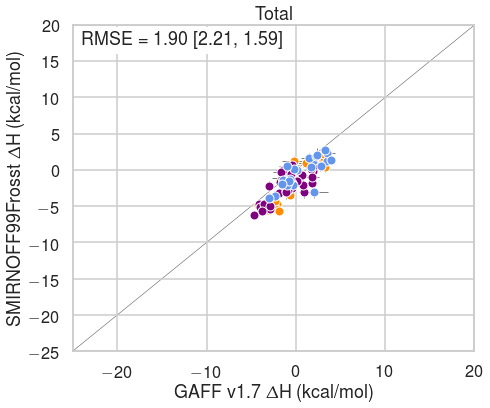

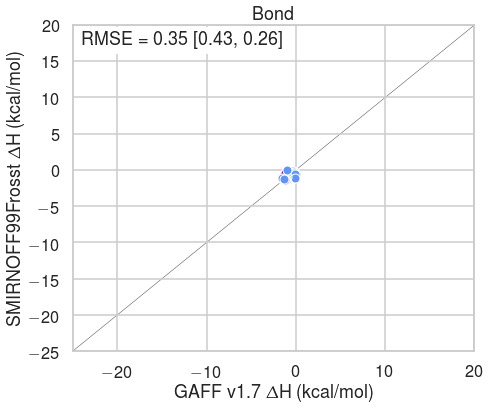

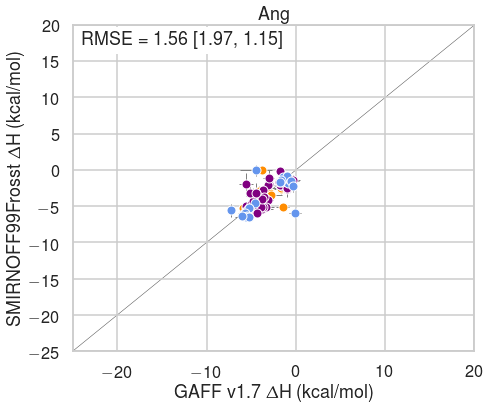

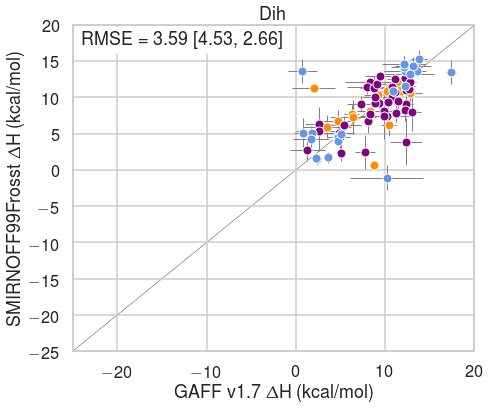

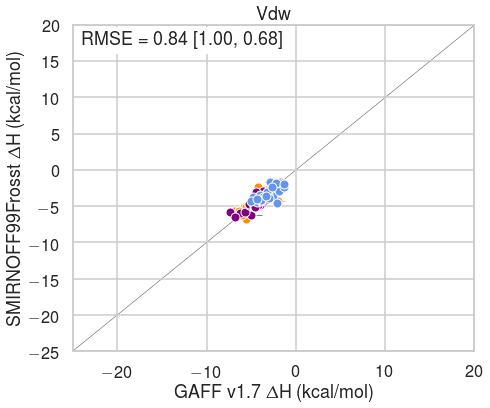

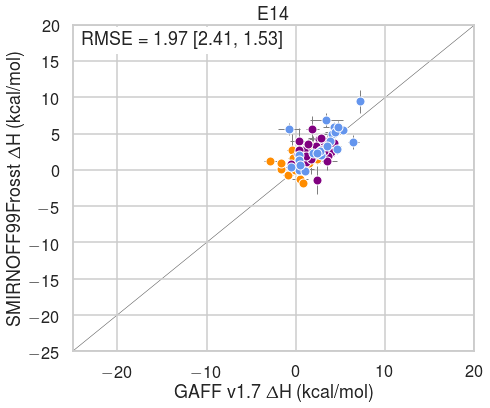

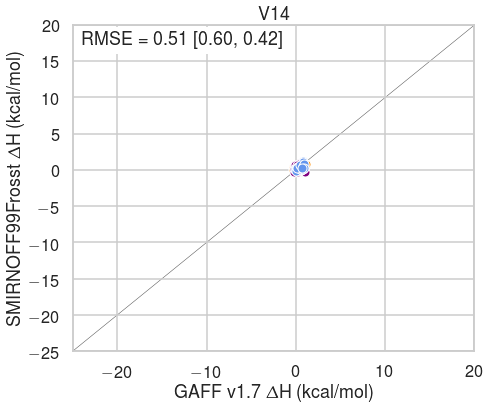

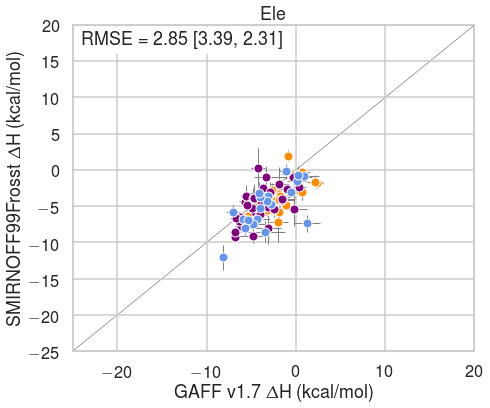

In [85]:
guest_types = combined["guest_type"].unique()

colors = {'aliphatic_ammoniums': 'darkorange',
          'cyclic_alcohols': 'cornflowerblue',
          'aliphatic_carboxylates': 'purple'
}


for component in ["total", "bond", "ang", "dih", "vdw", "e14", "v14", "ele"]:

    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

    for index, guest_type in enumerate(guest_types):
        df = combined[combined["guest_type"] == guest_type]
        df_x = df[df["ff"] == "bgbg_tip3p"]
        df_y = df[df["ff"] == "smirnoff"]
        ax.errorbar(
            df_x[component],
            df_y[component],
            xerr=df_x[f"{component}_sem"],
            yerr=df_y[f"{component}_sem"],
            fmt="o",
            c=colors[guest_type],
            markeredgecolor="w",
            ecolor="0.5",
            elinewidth=1,
        )

    smirnoff = combined[combined["ff"] == "smirnoff"]
    bgbg = combined[combined["ff"] == "bgbg_tip3p"]
    statistics = bootstrap(bgbg[component].values,
                   bgbg[f"{component}_sem"].values,
                   smirnoff[component].values,
                   smirnoff[f"{component}_sem"].values,
                   cycles=1000)
    print(component)
    print(statistics)
    
    text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
    ax.annotate(
    text,
    xy=(-25 + 1, 20 - 1),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
)

    ax.set_title(component.title())
    ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
    ax.set_ylim(-25, 20)
    ax.set_xlim(-25, 20)
    ax.set_ylabel("SMIRNOFF99Frosst $\Delta$H (kcal/mol)", labelpad=5)
    ax.set_xlabel("GAFF v1.7 $\Delta$H (kcal/mol)", labelpad=5)

In [66]:
calculate = True
if calculate:
    combined.to_csv("combined.csv")
else:
    combined = pd.read_csv("combined.csv")

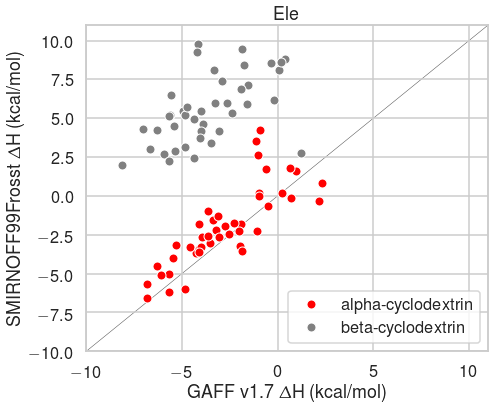

In [37]:
guest_types = combined["guest_type"].unique()

for component in ["ele"]:

    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))



    for CD in ["alpha-cyclodextrin", "beta-cyclodextrin"]:
        if CD == "alpha-cyclodextrin":
            tmp = combined[combined["system"].str[0] == "a"]
            
            df_x = tmp[tmp["ff"] == "bgbg_tip3p"]
            df_y = tmp[tmp["ff"] == "smirnoff"]
            ax.errorbar(
                df_x[component],
                df_y[component],
                xerr=None,
                yerr=None,
                fmt="o",
                c="red",
                markeredgecolor="w",
                ecolor="0.5",
                elinewidth=1,
                label=CD
            )
        else:
            tmp = combined[combined["system"].str[0] == "b"]
            
            df_x = tmp[tmp["ff"] == "bgbg_tip3p"]
            df_y = tmp[tmp["ff"] == "smirnoff"]
            ax.errorbar(
                df_x[component],
                df_y[component],
                xerr=None,
                yerr=None,
                fmt="o",
                c="grey",
                markeredgecolor="w",
                ecolor="0.5",
                elinewidth=1,
                label=CD
            )

        
    
    ax.set_title(component.title())
    ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
    plt.legend()
    ax.set_ylim(-10, 11)
    ax.set_xlim(-10, 11)
    ax.set_ylabel("SMIRNOFF99Frosst $\Delta$H (kcal/mol)", labelpad=5)
    ax.set_xlabel("GAFF v1.7 $\Delta$H (kcal/mol)", labelpad=5)
    

In [67]:
combined["short_system"] = ["-".join(row["system"].split("-")[0:2]) for _, row in combined.iterrows()]
combined_smirnoff = pd.DataFrame()

for hg in combined["short_system"].unique():
    df = combined[(combined["short_system"] == hg) & (combined["ff"] == "smirnoff")]
    for _, row in df.iterrows():
        if "p" in row["system"].split("-")[2]:
            primary_fe = row["total"]
            primary_sem = row["total_sem"]
            guest_type = row["guest_type"]
        else:
            secondary_fe = row["total"]
            secondary_sem = row["total_sem"]
    results = thermodynamic_bootstrap(primary_fe, primary_sem,
                           secondary_fe, secondary_sem)
    print(f"{hg} P: {primary_fe:+0.4f} ± {primary_sem:+0.2f} S: {secondary_fe:+0.2f} ± {secondary_sem:+0.2f} → Boot: {results['mean']:+0.2f} ± {results['sem']:+0.2f}")
    
    combined_smirnoff = combined_smirnoff.append(pd.DataFrame({'system': hg,
                                 'smirnoff' : results['mean'],
                                 'smirnoff_sem': results['sem'],
                                 'guest_type': guest_type
                                 }, index=[0]), ignore_index=True)

a-bam P: -0.4158 ± +0.28 S: -1.19 ± +0.35 → Boot: -1.36 ± +0.28
a-but P: -1.8585 ± +0.24 S: -0.67 ± +0.64 → Boot: -1.97 ± +0.24
a-cbu P: -2.1144 ± +0.22 S: -2.05 ± +0.32 → Boot: -2.53 ± +0.19
a-chp P: -1.3761 ± +0.33 S: -3.62 ± +0.39 → Boot: -3.66 ± +0.38
a-cpe P: -1.2969 ± +0.35 S: -1.95 ± +0.31 → Boot: -2.16 ± +0.25
a-coc P: -1.4586 ± +0.41 S: -3.87 ± +0.46 → Boot: -3.87 ± +0.44
a-hep P: -4.7057 ± +0.41 S: -4.72 ± +0.40 → Boot: -5.18 ± +0.30
a-ham P: -3.7096 ± +0.29 S: -4.70 ± +0.34 → Boot: -4.83 ± +0.28
a-hp6 P: -5.0855 ± +0.40 S: -4.75 ± +0.39 → Boot: -5.42 ± +0.30
a-hex P: -5.3618 ± +0.45 S: -3.98 ± +0.28 → Boot: -5.43 ± +0.40
a-hx2 P: -4.9946 ± +0.24 S: -3.29 ± +0.24 → Boot: -5.04 ± +0.22
a-hpa P: -4.2650 ± +0.25 S: -5.34 ± +0.66 → Boot: -5.46 ± +0.55
a-mba P: -0.0197 ± +0.47 S: -0.99 ± +0.42 → Boot: -1.15 ± +0.34
a-hx3 P: -3.1135 ± +0.31 S: -2.17 ± +0.61 → Boot: -3.29 ± +0.29
a-mhp P: -4.9829 ± +0.39 S: -4.87 ± +0.26 → Boot: -5.38 ± +0.25
a-mha P: -4.2896 ± +0.26 S: -3.22 ± +0.5

In [68]:
combined["short_system"] = ["-".join(row["system"].split("-")[0:2]) for _, row in combined.iterrows()]
combined_bgbg = pd.DataFrame()

for hg in combined["short_system"].unique():
    df = combined[(combined["short_system"] == hg) & (combined["ff"] == "bgbg_tip3p")]
    for _, row in df.iterrows():
        if "p" in row["system"].split("-")[2]:
            primary_fe = row["total"]
            primary_sem = row["total_sem"]
            guest_type = row["guest_type"]
        else:
            secondary_fe = row["total"]
            secondary_sem = row["total_sem"]
    results = thermodynamic_bootstrap(primary_fe, primary_sem,
                           secondary_fe, secondary_sem)
    print(f"{hg} P: {primary_fe:+0.4f} ± {primary_sem:+0.2f} S: {secondary_fe:+0.2f} ± {secondary_sem:+0.2f} → Boot: {results['mean']:+0.2f} ± {results['sem']:+0.2f}")
    
    combined_bgbg = combined_bgbg.append(pd.DataFrame({'system': hg,
                                 'bgbg' : results['mean'],
                                 'bgbg_sem': results['sem'],
                                 'guest_type': guest_type
                                 }, index=[0]), ignore_index=True)

a-bam P: +0.4380 ± +0.63 S: -1.35 ± +0.72 → Boot: -1.36 ± +0.65
a-but P: -0.0701 ± +0.69 S: -1.54 ± +0.29 → Boot: -1.62 ± +0.28
a-cbu P: -0.2842 ± +0.31 S: -0.98 ± +0.73 → Boot: -1.21 ± +0.51
a-chp P: -1.4365 ± +0.36 S: -2.37 ± +0.29 → Boot: -2.50 ± +0.25
a-cpe P: -0.6788 ± +0.60 S: -1.55 ± +0.30 → Boot: -1.72 ± +0.28
a-coc P: -0.7969 ± +0.31 S: -3.00 ± +0.32 → Boot: -3.01 ± +0.32
a-hep P: -3.6344 ± +0.30 S: -4.13 ± +0.42 → Boot: -4.40 ± +0.30
a-ham P: -2.5099 ± +0.40 S: -2.13 ± +0.42 → Boot: -2.82 ± +0.30
a-hp6 P: -3.9724 ± +0.23 S: -3.54 ± +0.30 → Boot: -4.22 ± +0.18
a-hex P: -2.9244 ± +0.45 S: -2.97 ± +0.35 → Boot: -3.42 ± +0.30
a-hx2 P: -2.8510 ± +0.26 S: -2.13 ± +0.41 → Boot: -3.04 ± +0.22
a-hpa P: -3.0882 ± +0.23 S: -2.18 ± +0.49 → Boot: -3.25 ± +0.22
a-mba P: -0.0572 ± +0.40 S: -0.35 ± +0.40 → Boot: -0.70 ± +0.30
a-hx3 P: -1.8584 ± +0.24 S: -3.02 ± +0.37 → Boot: -3.12 ± +0.31
a-mhp P: -3.8714 ± +0.30 S: -3.10 ± +0.27 → Boot: -4.03 ± +0.24
a-mha P: -2.3648 ± +0.35 S: -1.97 ± +0.3

In [69]:
experimental_data = pd.DataFrame()
for row in experimental_values.split("\n"):
    experimental_data = experimental_data.append(pd.DataFrame({'system': row.split('\t')[0],
                                 'exp' : float(row.split('\t')[1]),
                                 'exp_sem': float(row.split('\t')[2]),
                                 }, index=[0]), ignore_index=True)

In [70]:
all_data = pd.merge(combined_smirnoff, experimental_data, on="system")

In [71]:
all_data = pd.merge(combined_bgbg, all_data, on=["system", "guest_type"])

{'mean': {'slope': 0.82460175771122646, 'intercept': -0.4392945651066294, 'R': 0.64174813904425598, 'R**2': 0.42130767796407109, 'RMSE': 1.7157763944686786}, 'sem': {'slope': 0.17571899999342633, 'intercept': 0.55761885378472731, 'R': 0.097298530293656343, 'R**2': 0.12103597358590669, 'RMSE': 0.21849724303061202}}


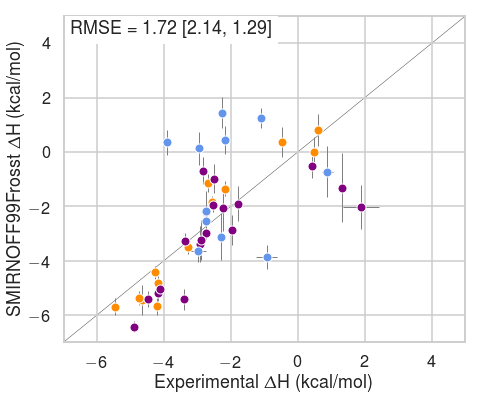

In [87]:
statistics = bootstrap(
    all_data["exp"],
    all_data["exp_sem"],
    all_data["smirnoff"],
    all_data["smirnoff_sem"],
    cycles=1000,
)

# fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
# ax.errorbar(
#     all_data["exp"],
#     all_data["smirnoff"],
#     xerr=all_data["exp_sem"],
#     yerr=all_data["smirnoff_sem"],
#     fmt="o",
#     c="k",
#     ecolor="0.5",
#     elinewidth=1,
# )

guest_types = all_data["guest_type"].unique()


colors = {'aliphatic_ammoniums': 'darkorange',
          'cyclic_alcohols': 'cornflowerblue',
          'aliphatic_carboxylates': 'purple'
}


fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))

for index, guest_type in enumerate(guest_types):
    tmp = all_data[all_data["guest_type"] == guest_type]
    ax.errorbar(
        tmp["exp"],
        tmp["smirnoff"],
        xerr=tmp["exp_sem"],
        yerr=tmp["smirnoff_sem"],
        fmt="o",
        c=colors[guest_type],
        markeredgecolor="w",
        ecolor="0.5",
        elinewidth=1,
    )


ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-7, 5)
ax.set_xlim(-7, 5)
ax.set_ylabel("SMIRNOFF99Frosst $\Delta$H (kcal/mol)", labelpad=5)
ax.set_xlabel("Experimental $\Delta$H (kcal/mol)", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.0, alpha=1)
text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
ax.annotate(
    text,
    xy=(-7 + 0.21, 5 - 0.21),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
)

plt.savefig("SMIRNOFF-vs-exp-DeltaH.pdf")
print(statistics)

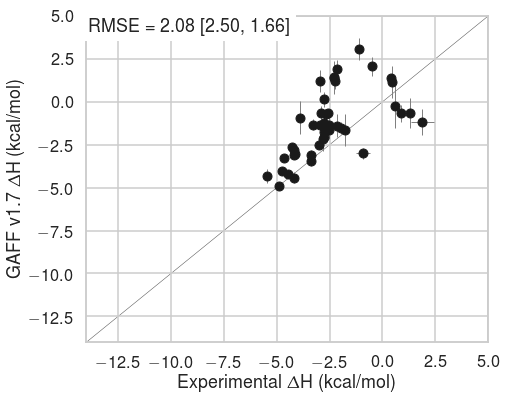

In [46]:
statistics = bootstrap(
    all_data["exp"],
    all_data["exp_sem"],
    all_data["bgbg"],
    all_data["bgbg_sem"],
    cycles=1000,
)

fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
ax.errorbar(
    all_data["exp"],
    all_data["bgbg"],
    xerr=all_data["exp_sem"],
    yerr=all_data["bgbg_sem"],
    fmt="o",
    c="k",
    ecolor="0.5",
    elinewidth=1,
)

ax.plot([-50, 50], [-50, 50], ls="-", c=".3", zorder=-1, lw="0.5")
ax.set_ylim(-14, 5)
ax.set_xlim(-14, 5)
ax.set_ylabel("GAFF v1.7 $\Delta$H (kcal/mol)", labelpad=5)
ax.set_xlabel("Experimental $\Delta$H (kcal/mol)", labelpad=5)
bbox_props = dict(boxstyle="square", fc="w", ec="k", lw=0.0, alpha=1)
text = f"RMSE = {statistics['mean']['RMSE']:0.2f} [{statistics['mean']['RMSE']+1.96*statistics['sem']['RMSE']:0.2f}, {statistics['mean']['RMSE']-1.96*statistics['sem']['RMSE']:0.2f}]"
ax.annotate(
    text,
    xy=(-14 + 0.11, 5 - 0.2),
    xycoords="data",
    size=18,
    bbox=bbox_props,
    horizontalalignment="left",
    verticalalignment="top",
)


In [45]:
statistics["mean"]

{'slope': 0.70643459575866641,
 'intercept': 0.47304810171295608,
 'R': 0.59012118637462141,
 'R**2': 0.3575077743786923,
 'RMSE': 2.0854322579034568}